# Neural Networks and Linear Regression

In [4]:
%matplotlib inline

from itertools import combinations

import pandas as pd
from datetime import datetime
import numpy as np
import os

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay\

import torch


import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
## Custom plotly plot styling

# Remove the red color in discrete color scale
px.colors.qualitative.Plotly = px.colors.qualitative.Plotly[:1] + px.colors.qualitative.Plotly[2:]

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font=dict(color="lightgreen"),
        colorscale=dict(sequential="Viridis"),
        colorway=px.colors.qualitative.Plotly)
)

pio.templates.default = "plotly+custom"

# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

## Load Data

In [2]:
data_path = os.path.normpath("../data/products_cleaned.csv")
df_az = pd.read_csv(data_path, dtype={"Category": "category"}, parse_dates=["Date Scraped"])

print(df_az.dtypes)
df_az

Asin                       object
Name                       object
Image Url                  object
Is Best Seller               bool
Stars                     float64
Reviews                   float64
Url                        object
Price                     float64
Date Scraped       datetime64[ns]
List Price                float64
Bought In Month           float64
Category                 category
dtype: object


,Asin,Name,Image Url,Is Best Seller,Stars,Reviews,Url,Price,Date Scraped,List Price,Bought In Month,Category
0,B0CSPPHXXV,Apple Watch Ultra 2 (GPS + Cellular 49mm) Rugg...,https://m.media-amazon.com/images/I/814xH1gpid...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Rugged-T...,699.97,2024-02-01,779.99,NaN,NaN
1,B0BDJ4MGFQ,AppleWatch Series 8 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/91WpS8h5Jv...,False,4.7,4100.0,https://www.amazon.com/Apple-Cellular-Starligh...,689.00,2024-02-01,799.00,NaN,NaN
2,B0CSV7LK7D,AppleWatch Series 9 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61DZ+Vezk0...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Smartwat...,679.00,2024-02-01,679.00,NaN,NaN
3,B0B8GHHD2F,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/51aQmgx9Ql...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
4,B0B8GDV9GN,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61O671oWHg...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Aluminum...,608.00,2024-02-01,608.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1389694,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,False,4.2,0.0,https://www.amazon.com/dp/B00R3LIKCO,14.95,2023-11-01,14.95,0.0,Men's Accessories
1389695,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,False,4.4,0.0,https://www.amazon.com/dp/B098BQ7ZQ3,33.99,2023-11-01,33.99,0.0,Men's Accessories
1389696,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,False,3.6,0.0,https://www.amazon.com/dp/B07X1MVNT1,8.54,2023-11-01,8.54,0.0,Men's Accessories
1389697,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,False,4.5,0.0,https://www.amazon.com/dp/B08XLBG8V9,54.36,2023-11-01,57.39,0.0,Men's Accessories


## Data Prep

In [12]:
df_lr = df_az[["Reviews", "Stars"]]
df_lr = df_lr.fillna(0)

print(df_lr.sample(10).to_markdown(index=False))

|   Reviews |   Stars |
|----------:|--------:|
|       515 |     4.2 |
|         0 |     3.7 |
|       502 |     4.3 |
|         0 |     4.4 |
|      3364 |     4.5 |
|      1106 |     3.8 |
|         0 |     4   |
|         0 |     4.8 |
|         0 |     4.6 |
|       164 |     4.4 |


## Linear Regression

### Model Selection

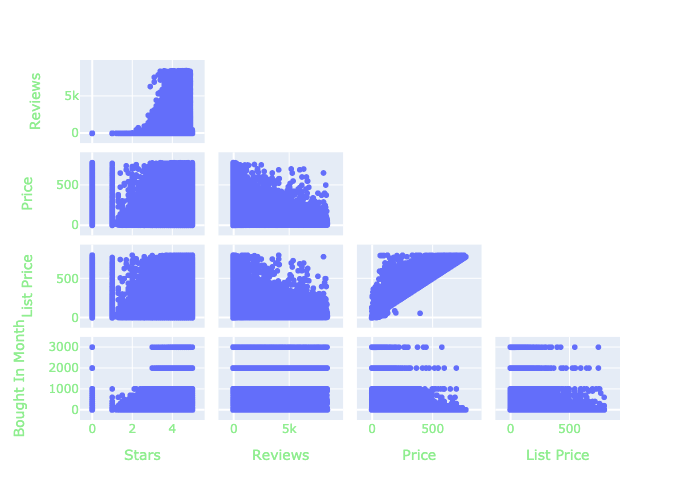

In [7]:
fig = px.scatter_matrix(df_az.select_dtypes("number"))
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.show(renderer="png")

### Running and Results